# Imports

In [7]:
# Imports
import os
import functools
import random
import ijson
import tqdm
import pandas as pd
import numpy as np
import javalang
import datetime
import enchant

import nltk
from nltk.corpus import stopwords
from collections import defaultdict, Counter
from termcolor import colored, cprint
from difflib import SequenceMatcher
from Levenshtein import distance as levenshtein_distance
import difflib



# Local code import 
from data_formatting_utils import subtokenize_code, subtokenize_comment # JIT tokenizer

# Matplotlb config
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.
plt.rcParams["legend.fontsize"] = 12.
plt.rcParams["figure.figsize"] = [8., 5.]

/var/folders/mk/mqpybhtd13lb7hwmhn3221340000kt/T/ipykernel_1078/2653789570.py:29: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


# Configuration

In [2]:
data_path = '/Users/Ivan.Pavlov/IdeaProjects/output_postprocessing'
unprocessed_data_path = "/Users/Ivan.Pavlov/IdeaProjects/new_dataset 4/"

# Data loading

In [3]:
dataset_files = os.listdir(data_path)

In [4]:
def read_json_file(path):
    with open(path, 'r') as json_file:
        iterator = iter(ijson.items(json_file, "item"))
        samples = []
        while True:
            try:
                sample = next(iterator)
                samples.append(sample)
            except:
                break
    return samples

# Simple Statistics

In [5]:
stats = defaultdict(list)
for pr_file in tqdm.tqdm(dataset_files):
    pr_path = os.path.join(data_path, pr_file)
    pr_samples = read_json_file(pr_path)
    
    inconsistent_samples = list(filter(lambda x: 'I' == x['label'][0], pr_samples))
    
    stats["consistent"].append(len(pr_samples) - len(inconsistent_samples))
    stats["inconsistent"].append(len(inconsistent_samples))
    #print(f"For project {pr_file} found {len(inconsistent_samples)} / {len(pr_samples)} inconsistencies")

100%|███████████████████████████████████████| 3862/3862 [02:07<00:00, 30.34it/s]


In [8]:
class_balance_df = pd.DataFrame.from_dict(stats)

In [9]:
class_balance_df.describe()

,consistent,inconsistent
count,3862.000000,3862.000000
mean,708.460124,23.664423
std,2935.411364,161.819996
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,355.750000,6.000000
max,118242.000000,6289.000000


### Class Balance

In [10]:
class_balance_df.sum()

consistent      2736073
inconsistent      91392
dtype: int64

In [11]:
C = 'consistent'
I = 'inconsistent'
npc = np.array(stats[C])
npi = np.array(stats[I])
# Filter uncommented projects
npi = npi[np.array(stats[I]) + np.array(stats[C]) != 0]
npc = npc[np.array(stats[I]) + np.array(stats[C]) != 0]

ratio = npi / (npc + npi)

### Documented projects ratio

In [12]:
print(f"Projects with non zero comments: {len(npi)} / {len(stats[C])}")

Projects with non zero comments: 1912 / 3862


In [13]:
mean_class_balance = ratio.mean()
print("Mean class balance: ", mean_class_balance)

Mean class balance:  0.029121657148161624


In [14]:
print("Mean and median for Commented projects inconsistencies count:", (npi.mean(), np.median(npi)))

Mean and median for Commented projects inconsistencies count: (47.79916317991632, 6.0)


In [15]:
print("Mean and median for Commented projects consistencies count:", (npc.mean(), np.median(npc)))

Mean and median for Commented projects consistencies count: (1431.0005230125523, 363.5)


In [16]:
print("Mean and median for Commented projects samples count:", ((npi + npc).mean(), np.median(npi + npc)))

Mean and median for Commented projects samples count: (1478.7996861924687, 378.5)


# Samples pretty print 

In [6]:
class SamplePrinter:
    def __init__(self, comment_diff_printer=None, code_diff_printer=None):
        self.comment_diff_printer = comment_diff_printer
        self.code_diff_printer = code_diff_printer
    
    @staticmethod
    def _show_diff(line_diffs):
        for diff_item in line_diffs:
            if diff_item.startswith('+'):
                cprint(diff_item, 'green')
            elif diff_item.startswith('-'):
                cprint(diff_item, 'red')
            else:
                print(diff_item)
    
    @staticmethod
    def _show_line_diffs(text1_lines, text2_lines): 
        SamplePrinter._show_diff(difflib.Differ().compare(text1_lines, text2_lines))
        
    @staticmethod
    def print_code_diffs(sample):
        SamplePrinter._show_line_diffs(sample['oldCode'].split('\n'), sample['newCode'].split('\n'))
    
    @staticmethod
    def print_comment_diffs(sample):
        SamplePrinter._show_line_diffs(sample['oldComment'].split('\n'), sample['newComment'].split('\n'))
        
    @staticmethod
    def _show_line_delimeter():
        print("---" * 20)
        
    @staticmethod
    def _show_sample_frame():
        print('#' * 60)
        
    def pretty_print(self, sample, print_stats = False, begin_frame=True, end_frame=True):
        if begin_frame:
            self._show_sample_frame()
        self._show_line_delimeter()
        print(f"Project {sample['project']}", end=' ')
        if sample['label'].startswith('I'):
            cprint(sample['label'], 'red', attrs=['bold'], end=' ')
        else:
            cprint(sample['label'], 'green', attrs=['bold'], end=' ')
        print("sample")
        self._show_line_delimeter()
        if not self.comment_diff_printer:
            self.print_comment_diffs(sample)
        else:
            self.comment_diff_printer(sample)
        self._show_line_delimeter()
        if not self.code_diff_printer:
            self.print_code_diffs(sample)
        else:
            self.code_diff_printer(sample)
        if print_stats:
            ...
        if end_frame:
            self._show_sample_frame()
    
    def print_list(self, samples):
        for i, s in enumerate(samples):
            if i == len(samples) - 1:
                self.pretty_print(s)
            else:
                self.pretty_print(s, end_frame=False)

                

# Get random sample

In [7]:
pr_index = 1

pr_file = dataset_files[pr_index]
print(pr_file)
pr_path = os.path.join(data_path, pr_file)
pr_samples = read_json_file(pr_path)
print(len(pr_samples))
random_sample = random.choice(pr_samples)
sp = SamplePrinter()
sp.pretty_print(random_sample)
#random_sample

apache#incubator-brooklyn.json
30
############################################################
------------------------------------------------------------
Project apache#incubator-brooklyn CONSISTENCY sample
------------------------------------------------------------
  /**
       * {@inheritDoc}
       */
------------------------------------------------------------
  
      public void start(final Collection<? extends Location> locations) {
          // Let everyone know we're starting up (so that the GUI shows the correct icon).
          sensors().set(Attributes.SERVICE_STATE_ACTUAL, Lifecycle.STARTING);
          try {
              // Get an unsubmitted task for starting all the children of this entity in parallel,
              // at the same location as this entity.
-             final TaskAdaptable<?> taskAdaptable = StartableMethods.startingChildren(this);
+             final TaskAdaptable<?> taskAdaptable = StartableMethods.startingChildren(this, locations);
?               

# Map on all samples 

In [8]:
def map_samples(func, context = None, files=dataset_files):
    for pr_file in tqdm.tqdm(files):
        pr_path = os.path.join(data_path, pr_file)
        pr_samples = read_json_file(pr_path)
        if context is not None:
            func(pr_samples, context)
        else:
            func(pr_samples)
    return context

# Samples utils

def get_consistent(samples):
    return list(filter(lambda x: not x['label'].startswith('I'), samples))

def get_inconsistent(samples):
    return list(filter(lambda x: x['label'].startswith('I'), samples))    

# Incorrect consistent samples

In [18]:
context = {} 
context['res'] = []

def same_commit(samples, context):
    for s in samples:
        if s['oldCommit'] == s['newCommit']:
            context['res'].append(s)
    return context

incorrect_samples = map_samples(
    same_commit,
    context
)

100%|███████████████████████████████████████████████████| 1855/1855 [00:59<00:00, 31.02it/s]


In [19]:
Counter([s['project'] for s in incorrect_samples['res']])

Counter({'hazelcast#hazelcast-hibernate': 24,
         'ibmruntimes#openj9-openjdk-jdk8': 1,
         'deeplearning4j#nd4j': 2,
         'cuba-platform#cuba': 1,
         'apache#commons-chain': 2,
         'gateship-one#odyssey': 1,
         'cloudera-labs#phoenix': 2,
         'apache#freemarker': 1,
         'apache#storm': 1,
         'eclipse#capella': 3,
         'apache#beam': 1,
         'google#sagetv': 1,
         'google#guava': 9,
         'jchambers#pushy': 2,
         'alibaba#dragonwell8_jdk': 1,
         'brix-cms#brix-cms': 1,
         'h2database#h2database': 1,
         'bumptech#glide': 1,
         'controlsfx#controlsfx': 1,
         'apache#lucene': 3,
         'cincheo#jsweet': 2,
         'bsc-wdc#compss': 2,
         'googleapis#java-bigtable-hbase': 1,
         'crdroidandroid#android_frameworks_base': 5,
         'androidx#androidx': 1,
         'apache#flink': 1,
         'jenkinsci#jenkins': 1,
         'google#copybara': 1,
         'hapifhir#hapi-fhir': 2

# Removed/Added count 

In [22]:
context = {}
context['added_code'] = defaultdict(list)
context['deleted_code'] = defaultdict(list)

context['added_doc'] = defaultdict(list)
context['deleted_doc'] = defaultdict(list)

def understand_opcode(opcode):
    inserted_count = 0
    deleted_count = 0
    for op in opcode:
        if op[0] == 'insert':
            inserted_count += op[4] - op[3]
        elif op[0] == 'replace':
            deleted_count += op[2] - op[1]
            inserted_count += op[4] - op[3]
        elif op[0] == 'delete':
            deleted_count += op[2] - op[1] 
    return inserted_count, deleted_count

def tokenize_code_alnum(code: str):
    return list(filter(lambda x: x.isalnum(), subtokenize_code(code).split(' ')))


def tokenize_doc_alnum(doc: str):
    return list(filter(lambda x: x.isalnum(), subtokenize_comment(doc).split(' ')))


def action_stats(samples, context):
    for s in samples:
        project = s['project']
        old_tokens, new_tokens = tokenize_code_alnum(s['oldCode']), tokenize_code_alnum(s['newCode'])
        inserted, deleted = understand_opcode(SequenceMatcher(None, old_tokens, new_tokens).get_opcodes())
        context['added_code'][project].append(inserted)
        context['deleted_code'][project].append(deleted)
    
    for s in get_inconsistent(samples):
        project = s['project']
        old_tokens, new_tokens = tokenize_doc_alnum(s['oldComment']), tokenize_doc_alnum(s['newComment'])
        inserted, deleted = understand_opcode(SequenceMatcher(None, old_tokens, new_tokens).get_opcodes())
        context['added_doc'][project].append(inserted)
        context['deleted_doc'][project].append(deleted)
    return context
    
    
    


In [23]:
add_remove_stats2 = map_samples(
    action_stats,
    context
)

100%|█████████████████████████████████████████████████| 1855/1855 [3:35:26<00:00,  6.97s/it]


In [25]:
mean_added_code = [np.mean(v) for p, v in add_remove_stats2['added_code'].items()]
mean_deleted_code = [np.mean(v) for p, v in add_remove_stats2['deleted_code'].items()]
mean_added_doc = [np.mean(v) for p, v in add_remove_stats2['added_doc'].items()]
mean_deleted_doc = [np.mean(v) for p, v in add_remove_stats2['deleted_doc'].items()]

In [27]:
import json
with open('add_remove_stats_1856.json', 'w') as json_file:
    json.dump(add_remove_stats2, json_file)

In [127]:
mean_changed_code = [np.mean(np.array(add_remove_stats['added_code'][p]) + np.array(add_remove_stats['deleted_code'][p])) 
                     for p in add_remove_stats['added_code'].keys()]
mean_changed_doc = [np.mean(np.array(add_remove_stats2['added_doc'][p]) + np.array(add_remove_stats2['deleted_doc'][p])) 
                     for p in add_remove_stats['added_doc'].keys()]

print('Median code change: ', np.median(mean_changed_code))
print('Median doc change: ', np.median(mean_changed_doc))

np.mean(mean_deleted_doc)

Median code change:  16.855422765370093
Median doc change:  10.0


6.466819032696893

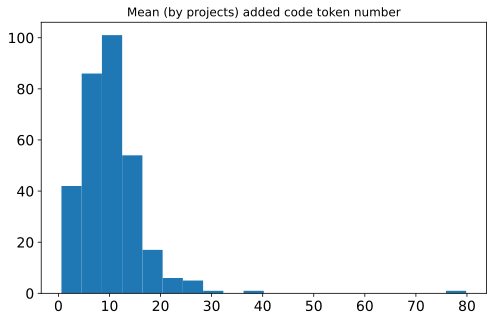

In [164]:

fig, axs = plt.subplots()
axs.hist(mean_added_code, bins=20)
axs.set_title('Mean (by projects) added code token number')
plt.show()

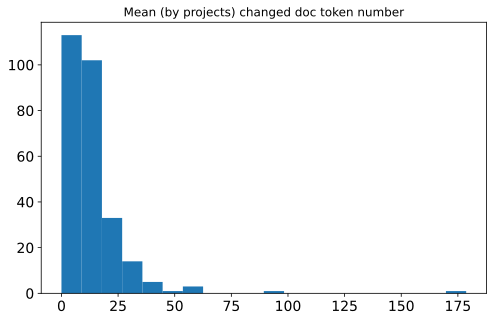

In [163]:
fig, axs = plt.subplots()
axs.hist(mean_changed_doc, bins=20)
axs.set_title('Mean (by projects) changed doc token number')
plt.show()

# Documented methods ratio 

In [152]:
# read statistics saved on ssh machine and copied to local machine to txt file
with open('/Users/Ivan.Pavlov/IdeaProjects/new_stats.jsonl', 'r') as doc_stats_file:
    stats_list = [json.loads(s) for s in doc_stats_file.read().strip().split('\n')]

In [169]:
methods_stats = [st['numOfMethods'] for st in stats_list if st['numOfMethods'] != 0]
doc_methods_stats = [st['numOfDocMethods'] for st in stats_list if st['numOfMethods'] != 0]

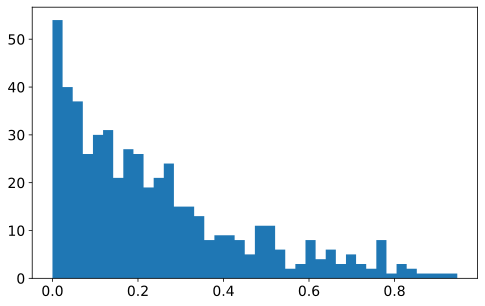

In [218]:
ratio = np.array(doc_methods_stats) / np.array(methods_stats)


fig, axs = plt.subplots()
axs.hist(ratio, bins=40, density=False, histtype='stepfilled')
#axs.set_title('Ratio of commented methods')
plt.savefig('doc_ratio.png')
plt.show()

# Refactorings statistics

In [ ]:
{
    "tags": [
        "hide_input",
    ]
}
context = defaultdict(int)

def refactorings_stats(samples, context):
    for s in samples:
        for r in ['isRenamed', 'isParamAdded', 'isParamRemoved',
                  'isReturnTypeChanged', 'isParamTypeChanged', 'isParamRenamed']:
            context[r] += int(s['metric'][r])
    return context
        

refactrs = map_samples(
    refactorings_stats,
    context
)

 49%|██████████████████████████████▏                               | 904/1855 [00:23<00:25, 36.86it/s]

Text(0.5, 1.0, 'Refactorings distribution')

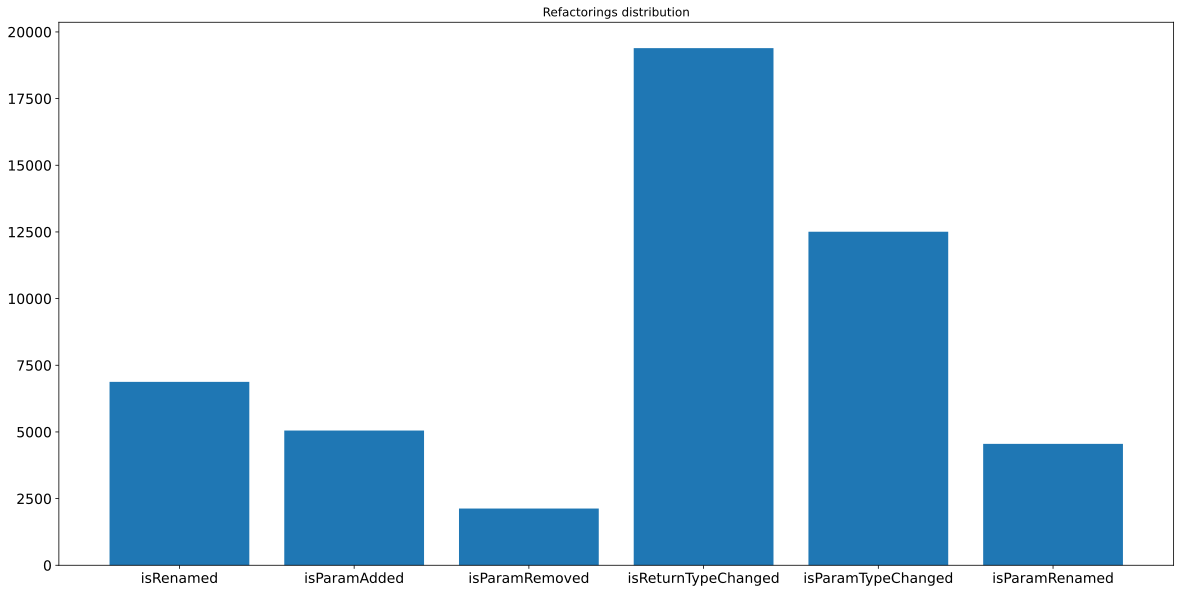

In [199]:
fig, axs = plt.subplots(figsize=(20, 10))
axs.bar(refactrs.keys(), refactrs.values())
axs.set_title('Refactorings distribution')

# Jumps Length

In [37]:
context = {}
context['jump'] = {}

def collect_jums(samples, context):
    for s in get_inconsistent(samples):
        pr = s['project']
        if pr not in context['jump']:
            context['jump'][pr] = []
        context['jump'][pr].append(s['jumpLength'])
    return context

all_jums = map_samples(
    collect_jums,
    context
)

100%|███████████████████████████████████████| 1855/1855 [00:57<00:00, 32.14it/s]


In [52]:
all_jums['jump']

{'apache#sqoop': [5, 1, 1],
 'edx#edx-app-android': [1, 9, 1, 6, 2, 1, 2, 1, 1, 2],
 'apache#incubator-hivemall': [5, 1, 6, 5],
 'apache#gora': [4,
  1,
  2,
  3,
  5,
  2,
  4,
  1,
  2,
  1,
  3,
  1,
  1,
  1,
  2,
  1,
  2,
  1,
  2,
  6,
  6,
  3,
  4,
  1,
  1,
  1,
  7,
  4],
 'flaxsearch#luwak': [1],
 'bonitasoft#bonita-studio': [5,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  

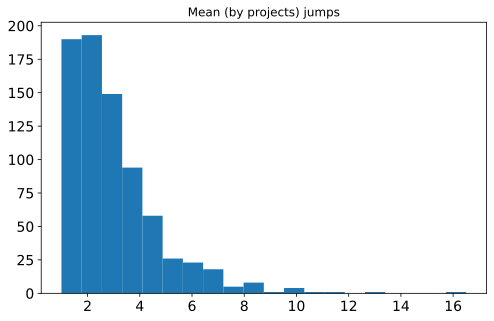

In [57]:
mean_j = {k:np.mean(v) for k, v in all_jums['jump'].items()}
lmj = list(mean_j.values())


fig, axs = plt.subplots()
axs.hist(lmj, bins=20)
axs.set_title('Mean (by projects) jumps')
plt.show()

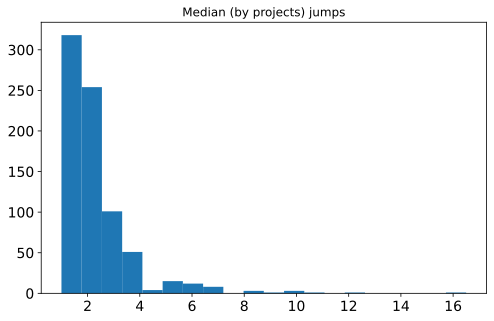

In [58]:
mean_j = {k:np.median(v) for k, v in all_jums['jump'].items()}
lmj = list(mean_j.values())


fig, axs = plt.subplots()
axs.hist(lmj, bins=20)
axs.set_title('Median (by projects) jumps')
plt.show()

In [65]:
ones = {k: v for k, v in all_jums['jump'].items() if np.mean(v) == 1.0}

ones

{'flaxsearch#luwak': [1],
 'gwtbootstrap3#gwtbootstrap3-extras': [1, 1],
 'influxdata#influxdb-client-java': [1, 1],
 'googleapis#java-spanner': [1, 1, 1, 1],
 'hortonworks#ratis': [1, 1, 1, 1, 1, 1],
 'jenkinsci#credentials-plugin': [1, 1],
 'airsonic#airsonic': [1],
 'jenkinsci#jacoco-plugin': [1],
 'eclipse-ee4j#jakartaee-tck': [1, 1, 1, 1],
 'confluentinc#rest-utils': [1, 1, 1, 1, 1],
 'craigwblake#redline': [1, 1],
 'hierynomus#sshj': [1],
 'apache#clerezza': [1, 1, 1],
 'apache#cloudstack': [1, 1, 1],
 'hazelcast#hazelcast-hibernate': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'alibaba#druid': [1],
 'apache#unomi': [1, 1, 1, 1],
 'castorini#anserini': [1],
 'apache#commons-chain': [1, 1],
 'apereo#java-cas-client': [1],
 'atlasmap#atlasmap': [1],
 'aikar#commands': [1],
 '1c-syntax#bsl-language-server': [1, 1, 1, 1],
 'confluentinc#kafka-stream

# XLNet

In [11]:
from transformers import XLNetTokenizer, XLNetForSequenceClassification
import torch

tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased')


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [24]:

inputs = tokenizer("Hello", return_tensors="pt")
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs = model(**inputs, labels=labels, output_hidden_states=True)
loss = outputs.loss
logits = outputs.logits

In [26]:
outputs.hidden_states[0].shape, outputs.hidden_states[1].shape

(torch.Size([1, 4, 768]), torch.Size([1, 4, 768]))

# bert-base-cased-finetuned-mrpc

In [37]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc", return_dict=True)
classes = ["not paraphrase", "is parapharse"]

In [38]:
# EXAMPLE 

sequence_0 = "The company HuggingFace is based in New York City"
sequence_1 = "Apples are especially bad for your health"
sequence_2 = "HuggingFace's headquarters are situated in Manhattan"

paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")

paraphrase_classification_logits = model(**paraphrase)[0]
not_paraphrase_classification_logits = model(**not_paraphrase)[0]

paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]


for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")

for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

not paraphrase: 10%
is parapharse: 90%
not paraphrase: 94%
is parapharse: 6%


In [35]:
paraphrase.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [40]:
# return max from softmax(logits)
def is_paraphrase(sentence1: str, sentence2: str) -> float:
    tokenized_sentences = tokenizer(sentence1, sentence2, return_tensors="pt")
    tokenized_sentences['token_type_ids'] = tokenized_sentences['token_type_ids'][:, :512]
    tokenized_sentences['input_ids'] = tokenized_sentences['input_ids'][:, :512]
    tokenized_sentences['attention_mask'] = tokenized_sentences['attention_mask'][:, :512]
    logits = model(**tokenized_sentences)[0]
    return torch.softmax(logits, dim=1).tolist()[0][1]

In [42]:
is_paraphrase("distance", "ditsance")

0.09106186777353287

In [12]:
context = {}
context['all'] = []

def detect_paraphrase(samples, context):
    for s in get_inconsistent(samples):
        s['paraphrase'] = is_paraphrase(s['oldComment'], s['newComment'])
        context['all'].append(s)
    return context

is_paraphrased = map_samples(
    detect_paraphrase, 
    context
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 48%|█████████████████▏                  | 888/1855 [2:07:43<2:19:05,  8.63s/it]


KeyboardInterrupt: 

In [36]:
import json
with open('paraphrase_inconsistent_backup_888.json', 'r') as backup:
#     json.dump(context['all'], backup, ensure_ascii=False, default=str)
    kek = {}
    kek = json.load(backup, ensure_ascii=False)

TypeError: __init__() got an unexpected keyword argument 'ensure_ascii'

In [23]:
paraphrase_detected_inconsistent_samples = context['all']

In [24]:
pdis = paraphrase_detected_inconsistent_samples

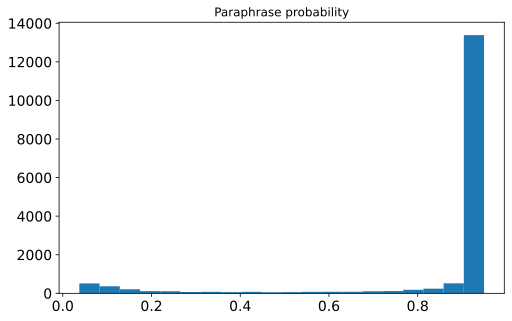

In [38]:
np_paraphrase = np.array([p['paraphrase'] for p in pdis])

fig, axs = plt.subplots()
axs.hist(np_paraphrase, bins=20)
axs.set_title('Paraphrase probability')
plt.show()

In [73]:
p5 = np.percentile(np_paraphrase, 5)
pdis_5 = [s for s in pdis if s['paraphrase'] <= p5]

p95 = np.percentile(np_paraphrase, 95)
pdis_95 = [s for s in pdis if s['paraphrase'] >= p95]

1164

In [105]:
sp.pretty_print(random.choice(pdis_5))

############################################################
------------------------------------------------------------
Project commercetools#commercetools-sync-java INCONSISTENCY sample
------------------------------------------------------------
  /**
       * Compares the {@link CustomFields} of an old resource {@link T} (for example {@link Category},
       * {@link io.sphere.sdk.products.Product}, etc..), to the {@link CustomFieldsDraft}, of a new
       * resource draft {@link S} (for example {@link CategoryDraft}, {@link io.sphere.sdk.products.ProductVariantDraft},
       * etc..), and returns a {@link List<UpdateAction>} as a result. If no update action is needed,
       * for example in the case where both the {@link CustomFields} and the {@link CustomFieldsDraft} are null, an empty
-      * {@link List<UpdateAction>} is returned. A {@link BaseOptions} instance is injected into the
+      * {@link List<UpdateAction>} is returned. A {@link BaseSyncOptions} instance is injecte

In [94]:
sp.pretty_print(random.choice(pdis_95))

############################################################
------------------------------------------------------------
Project bndtools#bnd INCONSISTENCY sample
------------------------------------------------------------
  /**
  	 * Get a bundle from one of the plugin repositories. If an exact version is
  	 * required we just return the first repository found (in declaration order
  	 * in the build.bnd file).
  	 * 
- 	 * @param bsn
- 	 *            The bundle symbolic name
? 	    ^^^^^^^^^

+ 	 * @param bsn The bundle symbolic name
? 	   ++++++ ^^^

+ 	 * @param range The version range
+ 	 * @param lowest set to LOWEST or HIGHEST
- 	 * @param range
- 	 *            The version range
- 	 * @param lowest
- 	 *            set to LOWEST or HIGHEST
  	 * @return the file object that points to the bundle or null if not found
+ 	 * @throws Exception when something goes wrong
- 	 * @throws Exception
- 	 *             when something goes wrong
  	 */
-------------------------------------

# Doc is unchanged 

In [84]:
unchanged_context = {}
unchanged_context['all'] = []

def gather_unchanged(samples, context):
    for s in get_inconsistent(samples):
        if s['oldComment'] == s['newComment']:
            unchanged_context['all'].append(s)
            
    return unchanged_context

unchanged = map_samples(
    gather_unchanged,
    unchanged_context
)['all']

100%|███████████████████████████████████████| 1855/1855 [00:54<00:00, 34.04it/s]


In [85]:
len(unchanged)

1961

# Code is unchanged

In [87]:
unchanged_context = {}
unchanged_context['all'] = []

def gather_unchanged(samples, context):
    for s in samples:
        if s['oldCode'] == s['newCode']:
            unchanged_context['all'].append(s)
            
    return unchanged_context

unchanged = map_samples(
    gather_unchanged,
    unchanged_context
all())['all']

100%|███████████████████████████████████████| 1855/1855 [00:55<00:00, 33.37it/s]


In [90]:
all([s['label'][0] == 'I' for s in unchanged])

True

# Sampling and clustering

In [9]:
def sample_from_projects(
    list_of_project_files=dataset_files,
    inconsistent=False,
    consistent=False, 
    filter_function=None):
    
    
    iteration_counter = 100
    while True:
        pr_file = random.choice(list_of_project_files)
        #pr_path = os.path.join(data_path, pr_file)
        pr_samples = read_json_file(pr_file)
        
        if not filter_function:
            filtered_samples = pr_samples
        else:
            filtered_samples = filter_function(pr_samples)
        
        if consistent:
            filtered_samples = get_consistent(filtered_samples)
        
        if inconsistent:
            filtered_samples = get_inconsistent(filtered_samples)
        
        if len(filtered_samples) > 0:
            break
        
        iteration_counter -= 1
        if iteration_counter == 0:
            print("Too many iteration happent, no sample found")
        
    random_sample = random.choice(filtered_samples)
    return random_sample

In [12]:
from IPython.display import clear_output

# Clustering 

clusters = []
freq_clusters = defaultdict(int)
clusters_samples = defaultdict(list)
count = 0

while True:
    count += 1
    
    # get sample
    sample = sample_from_projects()
    
    # show example
    sp.pretty_print(sample)
    
    # read cluster 
    print(f"Sample processed: {count}")
    print("Choose sample cluster")
    for i, c in enumerate(clusters):
        print(f"Type [{i}] for cluster {c}")
    
    # add cluster if needed
    print("Type [a] for adding cluster")
    print("Type [s] for showing cluster frequency")
    print("Type [q] for exit")
    print("Type [c] to continue")
    
    # process user input
    q = input()
    if q == 'a':
        print("Name new cluster")
        name = input()
        clusters.append(name)
        print(f"Cluster {name} created!")
        
    if q == 'q':
        # save and quit
        # todo: save smth
        print(freq_clusters)
        break
        
    if q == 's':
        print(freq_clusters)
    
    if q.isdigit():
        num = int(q)
        try:
            c = clusters[num]
            freq_clusters[c] += 1
            clusters_samples[c].append(sample)
        except:
            print("wrong cluster number")
        print("Saved sampled in cluster", c)
    
    if q == 'c':
        clear_output()
        continue
        
    input("Press enter to continue")
    clear_output()

############################################################
------------------------------------------------------------
Project apache#ant-ivy CONSISTENCY sample
------------------------------------------------------------
  /**
       * Gets a session from the cache or establishes a new session if necessary
       * 
       * @param host
       *            to connect to
       * @param port
       *            to use for session (-1 == use standard port)
       * @param username
       *            for the session to use
       * @param userPassword
       *            to use for authentication (optional)
       * @param pemFile
       *            File to use for public key authentication
       * @param pemPassword
       *            to use for accessing the pemFile (optional)
       * @param passFile
       *            to store credentials
       * @return session or null if not successful
       */
------------------------------------------------------------
  
      public S

In [17]:
import json
with open('clustered_samples_backup.json', 'w') as backup:
    json.dump(dict(clusters_samples), backup, ensure_ascii=False, default=str)



NameError: name 'clusters_samples' is not defined

# Clustering

In [10]:
from IPython.display import clear_output

def clustering(freqs=None, clusters_samples=None, printer=sp, consistent=False, inconsistent=False, list_of_project_files=[os.path.join(data_path, f) for f in dataset_files]):
    
    freq_clusters = freqs or defaultdict(int)
    clusters_samples = clusters_samples or defaultdict(list)
    clusters = list(clusters_samples.keys())
    count = sum(dict(freq_clusters).values())
    
    while True:
        count += 1

        # get sample
        sample = sample_from_projects(inconsistent=inconsistent, consistent=consistent, list_of_project_files=list_of_project_files)

        # show example
        printer.pretty_print(sample)

        # read cluster 
        print(f"Sample processed: {count}")
        print("Choose sample cluster")
        for i, c in enumerate(clusters):
            print(f"[{i}] | {c}")

        # add cluster if needed
        print("Type [a] for adding cluster")
        print("Type [s] for showing cluster frequency")
        print("Type [q] for exit")
        print("Type [c] to continue")

        # process user input
        q = input()

        if q == 's':
            print(freq_clusters)
            q = input()

        if q == 'a':
            print("Name new cluster")
            name = input()
            clusters.append(name)
            clusters_samples[name].append(sample)
            freq_clusters[name] += 1
            print(f"Cluster {name} created!")

        if q == 'q':
            # save and quit
            # todo: save smth
            print(freq_clusters)
            break


        if q.isdigit():
            num = int(q)
            try:
                c = clusters[num]
                freq_clusters[c] += 1
                clusters_samples[c].append(sample)
            except:
                print("wrong cluster number")
            print("Saved sampled in cluster", c)

        if q == 'c':
            clear_output()
            continue

        input("Press enter to continue")
        clear_output()
    return freq_clusters, clusters_samples

In [8]:
def detect_paraphrase(sample) -> bool: 
    comment1, comment2 = sample['oldComment'], sample['newComment']
    subtkns1 = subtokenize_comment(comment1).split()
    subtkns2 = subtokenize_comment(comment2).split()
    stops = set(stopwords.words('english'))
    filtered1 = Counter(filter(lambda x: x not in stops and x.isalnum(), subtkns1))
    filtered2 = Counter(filter(lambda x:x not in stops and x.isalnum(), subtkns2))
    if filtered1 == filtered2:
        return True
    return False

In [58]:
context = {}
context['count'] = 0

def count_paraphrase(samples, context):
    for s in samples:
        if 'inheritDoc' in s['oldComment'] or 'inheritDoc' in s['newComment']:
            context['count'] += 1
    return context

map_samples(
    count_paraphrase,
    context
)['count']

100%|█████████████████████████████████████████████████████████████| 1855/1855 [00:59<00:00, 31.33it/s]


52733

# Filtering 

In [11]:
filtered_data_dir = './filtered_data'

if not os.path.exists(filtered_data_dir):
    os.makedirs(filtered_data_dir)


def save_samples_json(samples, output_file):
    with open(output_file, 'w') as json_file:
        json.dump(samples, json_file, ensure_ascii=False, default=str)
    
def filter_samples(output_dir, input_files, filter_functions, input_dir=data_path):
    files = input_files
    total_samples = 0
    remained_samples = 0
    filter_functions_stats = defaultdict(int)
    
    for pr_file in tqdm.tqdm(files):
        # read samples
        pr_path = os.path.join(input_dir, pr_file)
        pr_samples = read_json_file(pr_path)
        total_samples += len(pr_samples)
        
        # drop projects with zero samples
        if not pr_samples:
            continue
        
        # Iterate dict of filter functions, apply every and count removed samples
        filtered_samples = pr_samples
        prev_len = len(filtered_samples)
        for f_name, ff in filter_functions.items():
            filtered_samples = ff(filtered_samples)
            filter_functions_stats[f_name] += prev_len - len(filtered_samples)
            prev_len = len(filtered_samples)
            
        remained_samples += len(filtered_samples)
    
        # save filtered samples
        output_file = os.path.join(output_dir, pr_file)
        save_samples_json(filtered_samples, output_file)
    
    # Show collected stat
    print(f"Was: {total_samples}, Now: {remained_samples}")
    print(filter_functions_stats)
    return filter_functions_stats


In [12]:
def compose2(f, g):
    return lambda *a, **kw: f(g(*a, **kw))

def compose(*fs):
    return functools.reduce(compose2, fs)

def make_list_filter(filter_sample, filter_inconsistent=False, filter_consistent=False):
    """
    filter_inconsistent - filter applied only to inconsistent samples, consistent are not filtered
    """
    if filter_consistent:
        return lambda samples: list(filter(lambda sample: True if sample['label'][0] == 'I' else filter_sample(sample), samples))
    if filter_inconsistent:
        return lambda samples: list(filter(lambda sample: True if sample['label'][0] == 'C' else filter_sample(sample), samples))
    return lambda x: list(filter(filter_sample, x))

def check_fields(fields, filter_function):
    return lambda sample: all([filter_function(sample[f]) for f in fields])

In [13]:
def detect_paraphrase(sample) -> bool:
    comment1, comment2 = sample['oldComment'], sample['newComment']
    subtkns1 = subtokenize_comment(comment1).split()
    subtkns2 = subtokenize_comment(comment2).split()
    stops = set(stopwords.words('english'))
    filtered1 = Counter(filter(lambda x: x not in stops and x.isalnum(), subtkns1))
    filtered2 = Counter(filter(lambda x:x not in stops and x.isalnum(), subtkns2))
    if filtered1 == filtered2:
        return True
    return False

filter_paraphrase_doc = make_list_filter(
    lambda x: not detect_paraphrase(x), filter_inconsistent=True
)

In [14]:
filter_inherit_doc = make_list_filter(
    check_fields(fields=['oldComment', 'newComment'],
                 filter_function=lambda x: 
                 'inheritDoc' not in x 
                 and 'inherit doc' not in x 
                 and 'inheritdoc' not in x
                 and '@see' not in x)
    )


In [15]:
filter_deprecated = make_list_filter(
    check_fields(
        fields=['oldComment', 'newComment', 'oldCode', 'newCode'],
        filter_function=lambda x: 'deprecated' not in x and 'Deprecated' not in x
    )
)

In [16]:
filter_non_brackets = make_list_filter(
       check_fields(
               fields=['oldCode', 'newCode'],
               filter_function=lambda x: '{' in x
       )
)

In [77]:
# Filter empty body methods

def is_empty_body(sample):
    return _is_code_empty(sample['oldCode']) or _is_code_empty(sample['newCode'])

def _is_code_empty(code: str) -> bool:
    left_brace_char, right_brace_char = '{', '}'
    try: 
        tree = javalang.parse.parse(
        f"""
        class Mock {left_brace_char}
            {code}
        {right_brace_char}
        """
        )
        body_len = len(tree.types[0].body[0].body) 
        return body_len == 0
    except:
        return False

filter_empty_body = make_list_filter(
        lambda x: not is_empty_body(x)
)

In [ ]:
# TODO: Filter same code consistency samples

In [ ]:
# TODO: Filter (adding @param to comment without changing params)

In [ ]:
# TODO: Filter changes only inside // comments (somehow?)

In [ ]:
# TODO: Filter typos!

# Filter typos

In [44]:
def sample_symm_difference(sample):
    old_tokens = [t for t in subtokenize_comment(sample['oldComment']).split() if t.isalnum()]
    new_tokens = [t for t in subtokenize_comment(sample['newComment']).split() if t.isalnum()]
    symm_diference = (set(old_tokens) - set(new_tokens)) | (set(new_tokens) - set(old_tokens))
    deleted = [t for t in old_tokens if t in symm_diference]
    added = [t for t in new_tokens if t in symm_diference]
    return added, deleted

In [49]:
enchant_dict = enchant.Dict('en_US')

def find_spell_corrections(sample):
    added, deleted = sample_symm_difference(sample)
    return _find_spell_pairs(added, deleted)

def _find_spell_pairs(added, deleted):
    SPELL_ERROR_SIZE = 3
    added, deleted = [w.lower() for w in added if w.isalpha()], [w.lower() for w in deleted if w.isalpha()]
    not_english_words = [w for w in deleted if not enchant_dict.check(w)]
    spell_corrections = []
    for w in not_english_words:
        close_words = [cw for cw in added if levenshtein_distance(w, cw) <= SPELL_ERROR_SIZE]
        correction_set = set(enchant_dict.suggest(w)) & set(close_words)
        if correction_set:
            spell_corrections.append((w, list(correction_set)[0]))
    return spell_corrections

def is_only_spell_corrections(sample):
    added, deleted = sample_symm_difference(sample)
    spell_pairs = _find_spell_pairs(added, deleted)
    # check if all added words - are spell corrections
    spell_added = set([s for f, s in spell_pairs])
    return len(set(added) - spell_added) == 0 and spell_added

In [50]:
filter_spell_corrections = make_list_filter(
        lambda x: not is_only_spell_corrections(x),
        filter_inconsistent=True
)

In [ ]:
# TODO: Filter methods with body like: {return null; }

In [78]:
import json
filter_samples(output_dir=filtered_data_dir, input_files=dataset_files, 
               filter_functions={'inherit': filter_inherit_doc,
                                 'paraphrase': filter_paraphrase_doc,
                                 'deprecated': filter_deprecated, 
                                 '{_inside': filter_non_brackets, 
                                 'spell_corrections': filter_spell_corrections,
                                 'javalang_empty_body': filter_empty_body})

100%|█████████████████████████████████████| 1855/1855 [6:08:08<00:00, 11.91s/it]

Was: 1591819, Now: 1376286
defaultdict(<class 'int'>, {'inherit': 121132, 'paraphrase': 8895, 'deprecated': 27703, '{_inside': 52989, 'spell_corrections': 184, 'javalang_empty_body': 4630})


defaultdict(int,
            {'inherit': 121132,
             'paraphrase': 8895,
             'deprecated': 27703,
             '{_inside': 52989,
             'spell_corrections': 184,
             'javalang_empty_body': 4630})

# Saving clustering

In [18]:
def read_clustering(file_path):
    """
    json: {desc: ..., freqs: ..., clusters: ...}
    """
    with open(file_path, 'r') as json_file:
        d = json.load(json_file)
    return d['desc'], d['freqs'], d['clusters']
        
    
def save_clustering(file_name, desc, freqs, clusters, clusters_out_path = './clusters_out'):
    with open(os.path.join(clusters_out_path, file_name), 'w') as cluster_file:
        json.dump(
                 {
                     'desc': desc, 
                     'freqs': freqs, 
                     'clusters': clusters
                 }, cluster_file)
    
    
def open_clustering(clusters_out_path = './clusters_out'):
    if not os.path.exists(clusters_out_path):
        os.mkdir(clusters_out_path)
    
    json_files = list(sorted(
        [p for p in os.listdir(clusters_out_path) if p.endswith('json')], 
        key=lambda x: os.path.getmtime(os.path.join(clusters_out_path, x))))
    
    if json_files:
        last_file_name = json_files[-1]
        #try:
        last_desc, last_freq, last_clusters = read_clustering(os.path.join(clusters_out_path, last_file_name))
        q = input(f'Continue previous clustering? Description: {last_desc} | [y]/n')
        if q == 'y' or q =='':
            print(f"Loaded file with {len(last_clusters)} clusters")
            return last_file_name, last_desc, defaultdict(int, last_freq), defaultdict(list, last_clusters)
        #except Exception as e:
        #    print("Can't load last saved file,", e)
            
    q = input("Enter new file description (without .json)")
    now = datetime.datetime.now()
    new_name = f'{now.strftime("%Y-%m-%d#%H-%M-%S")}.json'   
    
    with open(os.path.join(clusters_out_path, new_name), 'w') as new_file:
        True
    
    return new_name, q, defaultdict(int), defaultdict(list)
    
            

# Симметрическая разность комментариев

Хотим посмотреть на симметрическую разность комментариев (до и после), чтобы понять какие токены добавляются
К этому можно применить spellchecker?

Давайте кластеризуем ~50 примеров изменений комментариев (получается inconsistency) примеров
Примеры берем из текущего отфильтрованного датасета: без Counter дупликатов, inherit, deprecated





In [19]:
def symmetric_difference_comment_printer(sample):
    SamplePrinter.print_comment_diffs(sample)
    print('~' * 30)
    
    old_tokens = [t for t in subtokenize_comment(sample['oldComment']).split() if t.isalnum()]
    new_tokens = [t for t in subtokenize_comment(sample['newComment']).split() if t.isalnum()]
    symm_diference = (set(old_tokens) - set(new_tokens)) | (set(new_tokens) - set(old_tokens))
    
    print(f"Tokens in symm. difference: {len(symm_diference)}")
    
    cprint("Deleted: ", 'red', attrs=['bold'])
    print_pos = 0
    deleted = [t for t in old_tokens if t in symm_diference]
    added = [t for t in new_tokens if t in symm_diference]
    for i, t in enumerate(deleted):
        if i % 16 == 15:
            print()
        cprint(t, 'red', end=' ')
    print()
    
    cprint("Added: ", 'green', attrs=['bold'])
    for i, t in enumerate(added):
        if i % 16 == 15:
            print()
        cprint(t, 'green', end=' ')
    print()

In [20]:
symm_printer = SamplePrinter(comment_diff_printer=symmetric_difference_comment_printer)

fname, desc, freqs, cluster = open_clustering()
freqs, clusters_samples = clustering(
    clusters_samples=cluster,
    freqs=freqs,
    printer=symm_printer, 
    inconsistent=True, 
    list_of_project_files=[os.path.join(filtered_data_dir, f) for f in os.listdir(filtered_data_dir)])
save_clustering(fname, desc, freqs, clusters_samples)

Continue previous clustering? Description: Clustering comments (viewing symmetrical difference) | [y]/n t y
Enter new file description (without .json) 


############################################################
------------------------------------------------------------
Project cerberustesting#cerberus-source INCONSISTENCY sample
------------------------------------------------------------
  /**
       * Gets all properties names contained into the given {@link String}
       *
       * <p>
       * A property is defined by including its name between two '%' character.
       * </p>
       *
       * @param str the {@link String} to get all properties
+      * @param variableType
       * @return a list of properties contained into the given {@link String}
       */
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Tokens in symm. difference: 2
Deleted: 

Added: 
variable type 
------------------------------------------------------------
  
      private List<String> getPropertiesListFromString(String str) {
          List<String> properties = new ArrayList<String>();
+         LOG.debug("Starting to guess properties from string : " + str);
         

 q


defaultdict(<class 'int'>, {})
